Data Date Range:
    <br />Start time: 2016-05-05 09:40:26
    <br />End time: 2018-01-17 01:59:42
    
#### This notebook generates the following table:
- rec_seed_info_raw: a table with all the recommended trailers, loginID, datetime, corresponding movieIds, information about the movie, and the associated algorithms.

- rec_movieinfo: similar to rec_seed_info_raw, but without datetime, which is replaced with age


#### Note:

We check how many trailers are recommended in each login session, but this does not produce any new csv files.

We check how many times each trailers are recommended, but did not produce any files


### Generate a table with all recommendations, the popularities, ratings, and age of movies, and algorithm assignment ###

Note that 'recommendations' are different from total_played or rec_played. Total_played refers to all trailers played; rec_played refers to recommendations clicked; 

Here, we examine recommendations - all trailers that have appeared in the recommendation list.


### Import

In [4]:
import pandas as pd
import numpy as np

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [6]:
# The key of the dictionary will be movieId, 
# the value of the dictionary will be a list of 3 items: avgRating, popRank, and age
movies={}

#### Access the database. Get information of all movies and their popularity, avgRating, and release date. Store them in a dictionary. 

In [7]:
import pymysql.cursors

# Connect to the database
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")
#                              cursorclass=pymysql.cursors.DictCursor)

try:
    with connection.cursor() as cursor:
        # Drop those whose avgRating != 0 and filmReleaseDate is not invalid 
        sql = "select * from movie_data where movieStatus=2 and rowType=11 and avgRating != 0 and filmReleaseDate != 0000-00-00"
        cursor.execute(sql)
        for row in cursor:
            movie_info = []
            # Add avgRating to list
            movie_info.append(row[9])
            # Add popularity to list
            movie_info.append(row[29])
            # Add release date to list
            movie_info.append(row[4])

            movies[int(row[0])] = movie_info

finally:
    connection.close()

In [8]:
print(len(movies))
movies[4612]


48244


[3.78214, 5, datetime.date(1990, 5, 25)]

#### Get a list of recommendations that appeared in a specific login session, and the algorithm associated with the session. 

We only fetch data before 2018-01-17 01:59:42

Session ID is helpful to match the recommendations a user received with information about the recommendations, especially their age (which is the time difference between film release date and date when they were recommended) 

In [11]:
# Connect to the database
import pymysql.cursors
import json



# The key of movie_logins will be loginId, value will be the list of movieIds recommended
# in this login session. 
movie_logins = {}

# We use algorithms to track the algorithm that recommends the trailer;
algorithms = []

# Recommendations tracks the trailers recommended;
recommendations = []
date = []
loginIds = []
seedMovie = []

# Users might view multiple trailers in one login. Each time they open the model to watch a new trailer, we call it a new session.
sessionIds = []
userIds = []
positions = []

# We will use these lists to generate a table later. 

# Connect to the database
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        sql_mlusers = "select userId from user_data where excludeFromExperiments='Y'"
        cursor.execute(sql_mlusers)
        mlusers = [str(item[0]) for item in cursor.fetchall()]
        
        mlusers = ",".join(mlusers)
        
        sql = """
        SELECT log_trailer_actions.userId, log_trailer_actions.loginId, log_trailer_actions.logJson, log_trailer_actions.action, log_trailer_actions.tstamp, expt_trailer.recommenderId,log_trailer_actions.positionInList
        FROM expt_trailer
        LEFT JOIN log_trailer_actions
        ON log_trailer_actions.loginId = expt_trailer.loginId
        WHERE log_trailer_actions.action IN ('TrailerModalLaunched','RecommendationsRefreshed') and log_trailer_actions.tstamp < '2018-01-17 01:59:42' and log_trailer_actions.userId NOT IN (%s) 
        ORDER BY log_trailer_actions.loginId,log_trailer_actions.tstamp
        """ % mlusers
        cursor.execute(sql)
        
        # The first loginId is a dummy
        loginIds.append(0)
        sessionId = 0
        
        for result in cursor:
            movie_logins[result[1]] = []
            logjson = json.loads(result[2])
             
            if (result[3] == 'TrailerModalLaunched'):
                mylist = logjson['displayedRecommendations'][1:-1].split(',')

                if (loginIds[len(loginIds)-2] != result[1]):
                    sessionId = 1
                else:
                    sessionId = sessionId+1
                
                
                # Exclude the first item because it's not a recommendation
                for i in range (1, len(mylist)):
                    movieId = mylist[i]
                    recommendations.append((int(movieId)))
                    positions.append(int(i))
                    algorithms.append(result[5])
                    date.append(result[4])
                    movie_logins[result[1]].append(int(movieId))
                    loginIds.append(result[1])
                    seedMovie.append(mylist[0])
                    sessionIds.append(sessionId)
                    userIds.append(result[0])
                    
            else:
                mylist = logjson['recommendationList'][1:-1].split(',')
                
                # Exclude the first item because it's not a recommendation
                for i in range (1, len(mylist)):
                    recommendations.append(int(movieId))
                    positions.append(int(i))
                    algorithms.append(result[5])
                    date.append(result[4])

                    movie_logins[result[1]].append(int(movieId))
                    loginIds.append(result[1])
                    seedMovie.append(mylist[0])
                    sessionIds.append(sessionId)
                    userIds.append(result[0])
            
finally: 
    connection.close()


In [13]:
#Remove the dummy from loginIds. Don't run this block twice!!
loginIds = loginIds[1:]
print(len(seedMovie))
print(len(loginIds))

1867083
1867083


In [14]:
print(len(sessionIds))

1867083


#### Recommendations and their seed movies in a dataframe, with algorithm assignment ⬇️

In [22]:
# Create a dataframe with all recommendations and the corrsponding algorithm.
d = {'loginId': loginIds, 'movieId': recommendations, 'Algorithm': algorithms, 'Datetime': date, 'SeedMovie': seedMovie, 'sessionIds': sessionIds,'userId':userIds,'position':positions}
recs_info = pd.DataFrame(data=d)




In [23]:
recs_info = recs_info.dropna()

In [24]:
recs_info['SeedMovie'] = recs_info['SeedMovie'].astype(int)

In [25]:
recs_info.count()

Algorithm     1867083
Datetime      1867083
SeedMovie     1867083
loginId       1867083
movieId       1867083
position      1867083
sessionIds    1867083
userId        1867083
dtype: int64

#### Match all recommendations with their corresponding popularity/popRanks, avgRating and release date

In [21]:
# This block might take a few minutes

# Use three lists to store the avgRatings, popularityLastYear, and release dates of the all recommendations
avgRating_list = []
popularity_list = []
release_date = []

# Reminder: The popularity of each movie is sto|red in the dictionary 'movies'
# Iterate through the dataframe we just created; get information about their popularity in 'movies',
# append the information in the lists;
for index, row in df_nona.iterrows():
    key = row['movieId']
    # Not every movie is in the movies list...
    if (key in movies):
        avgRating_list.append(movies[key][0])
        popularity_list.append(movies[key][1])
        release_date.append(movies[key][2])

    else:
        avgRating_list.append(None)
        popularity_list.append(None)
        release_date.append(None)
 

In [24]:
# Check 
print(len(avgRating_list))
print(movies[1694][1])



1867083
30


In [27]:
### Get information for seed movies

avgRating_list_seed = []
popularity_list_seed = []
release_date_seed = []

# Reminder: The popularity of each movie is stored in the dictionary 'movies'
# Iterate through the dataframe we just created; get information about their popularity in 'movies',
# append the information in the lists;
for index, row in df_nona.iterrows():
    seedmovie = row['SeedMovie']
    # Not every movie is in the movies list
    if (seedmovie in movies):
        avgRating_list_seed.append(movies[seedmovie][0])
        popularity_list_seed.append(movies[seedmovie][1])
        release_date_seed.append(movies[seedmovie][2])

    else:
        avgRating_list_seed.append(None)
        popularity_list_seed.append(None)
        release_date_seed.append(None)
 

In [26]:
# Append the information about movie popularity to the table we just crated

recs_info['avgRating'] = avgRating_list
recs_info['popularityLastYear'] = popularity_list
recs_info['release_date'] = release_date
recs_info.head(20)


,Algorithm,Datetime,SeedMovie,loginId,movieId,position,sessionIds,userId,avgRating,popularityLastYear,release_date
0,PredictedRating,2016-09-12 13:53:04,118985,008C57f,318,1,1,276159,4.42567,6718.0,1994-09-23
1,PredictedRating,2016-09-12 13:53:04,118985,008C57f,93721,2,1,276159,3.95484,216.0,2011-06-15
2,PredictedRating,2016-09-12 13:53:04,118985,008C57f,148626,3,1,276159,4.01445,1683.0,2015-12-12
3,PredictedRating,2016-09-12 13:53:04,118985,008C57f,2966,4,1,276159,3.93489,89.0,1999-10-15
4,PredictedRating,2016-09-12 13:53:04,118985,008C57f,81845,5,1,276159,3.93316,1903.0,2010-11-26
5,PredictedRating,2016-09-12 13:53:04,118985,008C57f,142488,6,1,276159,4.07910,1134.0,2015-11-06
6,PredictedRating,2016-09-12 13:53:04,118985,008C57f,106100,7,1,276159,3.91153,1303.0,2013-10-10
7,PredictedRating,2016-09-12 13:53:04,118985,008C57f,106889,8,1,276159,3.97046,41.0,2013-12-31
8,PredictedRating,2016-09-12 13:53:04,118985,008C57f,678,9,1,276159,4.07006,19.0,1994-01-24
9,PredictedRating,2016-09-12 13:53:04,118985,008C57f,110669,10,1,276159,NaN,NaN,None


In [28]:
# Append the information about movie popularity for the seed movies as well

recs_info['avgRating_seedmovie'] = avgRating_list_seed
recs_info['popularityLastYear_seedmovie'] = popularity_list_seed
recs_info['release_date_seedmovie'] = release_date_seed

In [30]:
recs_info.dtypes

Algorithm                               object
Datetime                        datetime64[ns]
SeedMovie                                int64
loginId                                 object
movieId                                  int64
position                                 int64
sessionIds                               int64
userId                                   int64
avgRating                              float64
popularityLastYear                     float64
release_date                            object
avgRating_seedmovie                    float64
popularityLastYear_seedmovie           float64
release_date_seedmovie                  object
dtype: object

#### Get the 'age' of each recommendation by calculating the difference between film release date and time it's recommended ⬇️

In [38]:
# This section finds out the age of each movie when its trailer is played
from datetime import datetime

# Find the age of each movie when it's played
ageAtViewDate = []
ageAtViewDate_seedmovie = []

fmt = '%Y-%m-%d %H:%M:%S'

for index, row in recs_info.iterrows():
    time1 = row[1].to_pydatetime().date()
    
    # Double check the index for them
    time2 = row[10]
    
    # Deal with bad data
    if (time1 == '0000-00-00' or time2 == '0000-00-00'):
        ageAtViewDate.append(None)
        continue
    elif (time1 == None or time2 == None):
        ageAtViewDate.append(None)
        continue
    else:
        this_age = time1-time2
        ageAtViewDate.append(this_age)
        

In [39]:
recs_info['age'] = ageAtViewDate


In [40]:
recs_info2 = recs_info.dropna().copy()
recs_info2['ageMonth'] = recs_info2['age'].astype('timedelta64[D]')/30
recs_info2=np.round(recs_info2,decimals=2)

In [41]:
recs_info2.head()

,Algorithm,Datetime,SeedMovie,loginId,movieId,position,sessionIds,userId,avgRating,popularityLastYear,release_date,avgRating_seedmovie,popularityLastYear_seedmovie,release_date_seedmovie,age,ageMonth
0,PredictedRating,2016-09-12 13:53:04,118985,008C57f,318,1,1,276159,4.43,6718.0,1994-09-23,3.4,142.0,2014-12-25,8025 days,267.50
1,PredictedRating,2016-09-12 13:53:04,118985,008C57f,93721,2,1,276159,3.95,216.0,2011-06-15,3.4,142.0,2014-12-25,1916 days,63.87
2,PredictedRating,2016-09-12 13:53:04,118985,008C57f,148626,3,1,276159,4.01,1683.0,2015-12-12,3.4,142.0,2014-12-25,275 days,9.17
3,PredictedRating,2016-09-12 13:53:04,118985,008C57f,2966,4,1,276159,3.93,89.0,1999-10-15,3.4,142.0,2014-12-25,6177 days,205.90
4,PredictedRating,2016-09-12 13:53:04,118985,008C57f,81845,5,1,276159,3.93,1903.0,2010-11-26,3.4,142.0,2014-12-25,2117 days,70.57


#### Get the age of seed movies 

In [42]:
# This section finds out the age of each seedmovie

# This part takes a few minutes...

from datetime import datetime


ageAtViewDate_seedmovie = []

fmt = '%Y-%m-%d %H:%M:%S'

for index, row in recs_info2.iterrows():
    # Get date for seed movie 
    time3 = row[1].to_pydatetime().date()
    
    # Double check column index is correct
    time4 = row[13] 
    
    if (time3 == '0000-00-00' or time4 == '0000-00-00'):
        ageAtViewDate_seedmovie.append(None)
        continue
        
    elif (time3 == None or time4 == None):
        ageAtViewDate_seedmovie.append(None)
        continue
    else:
        seedmovie_age = time3-time4
        ageAtViewDate_seedmovie.append(seedmovie_age)


In [ ]:
recs_info2['age_seedmovie'] = ageAtViewDate_seedmovie

In [57]:
recs_info2 = recs_info2.dropna().copy()
recs_info2['age_seedmovie_month'] = (recs_info2['age_seedmovie']/30).astype('timedelta64[D]')

KeyError: 'age_seedmovie'

In [45]:
recs_info2=np.round(recs_info2,decimals=2)
recs_info2.head(10)

,Algorithm,Datetime,SeedMovie,loginId,movieId,position,sessionIds,userId,avgRating,popularityLastYear,release_date,avgRating_seedmovie,popularityLastYear_seedmovie,release_date_seedmovie,age,ageMonth,age_seedmovie,age_seedmovie_month
0,PredictedRating,2016-09-12 13:53:04,118985,008C57f,318,1,1,276159,4.43,6718.0,1994-09-23,3.4,142.0,2014-12-25,8025 days,267.50,"627 days, 0:00:00",20.0
1,PredictedRating,2016-09-12 13:53:04,118985,008C57f,93721,2,1,276159,3.95,216.0,2011-06-15,3.4,142.0,2014-12-25,1916 days,63.87,"627 days, 0:00:00",20.0
2,PredictedRating,2016-09-12 13:53:04,118985,008C57f,148626,3,1,276159,4.01,1683.0,2015-12-12,3.4,142.0,2014-12-25,275 days,9.17,"627 days, 0:00:00",20.0
3,PredictedRating,2016-09-12 13:53:04,118985,008C57f,2966,4,1,276159,3.93,89.0,1999-10-15,3.4,142.0,2014-12-25,6177 days,205.90,"627 days, 0:00:00",20.0
4,PredictedRating,2016-09-12 13:53:04,118985,008C57f,81845,5,1,276159,3.93,1903.0,2010-11-26,3.4,142.0,2014-12-25,2117 days,70.57,"627 days, 0:00:00",20.0
5,PredictedRating,2016-09-12 13:53:04,118985,008C57f,142488,6,1,276159,4.08,1134.0,2015-11-06,3.4,142.0,2014-12-25,311 days,10.37,"627 days, 0:00:00",20.0
6,PredictedRating,2016-09-12 13:53:04,118985,008C57f,106100,7,1,276159,3.91,1303.0,2013-10-10,3.4,142.0,2014-12-25,1068 days,35.60,"627 days, 0:00:00",20.0
7,PredictedRating,2016-09-12 13:53:04,118985,008C57f,106889,8,1,276159,3.97,41.0,2013-12-31,3.4,142.0,2014-12-25,986 days,32.87,"627 days, 0:00:00",20.0
8,PredictedRating,2016-09-12 13:53:04,118985,008C57f,678,9,1,276159,4.07,19.0,1994-01-24,3.4,142.0,2014-12-25,8267 days,275.57,"627 days, 0:00:00",20.0
10,PredictedRating,2016-09-12 13:53:04,118985,008C57f,4995,11,1,276159,3.96,2776.0,2002-01-04,3.4,142.0,2014-12-25,5365 days,178.83,"627 days, 0:00:00",20.0


In [46]:
recs_info2 = recs_info2[recs_info2['ageMonth']>=0].copy()

In [47]:
datetime.strptime('1874-12-08', "%Y-%m-%d").date()

datetime.date(1874, 12, 8)

In [48]:
# Remove invalid release dates
recs_info2 = recs_info2[recs_info2['release_date']>=datetime.strptime('1874-12-08', "%Y-%m-%d").date()].copy()
recs_info2 = recs_info2[recs_info2['release_date_seedmovie']>=datetime.strptime('1874-12-08', "%Y-%m-%d").date()].copy()

In [51]:
recs_info2.drop("age_seedmovie",axis=1,inplace=True)


In [55]:
recs_info2.count()

Algorithm                       1779642
Datetime                        1779642
SeedMovie                       1779642
loginId                         1779642
movieId                         1779642
position                        1779642
sessionIds                      1779642
userId                          1779642
avgRating                       1779642
popularityLastYear              1779642
release_date                    1779642
avgRating_seedmovie             1779642
popularityLastYear_seedmovie    1779642
release_date_seedmovie          1779642
age                             1779642
ageMonth                        1779642
age_seedmovie_month             1779642
dtype: int64

In [50]:
#df_new.to_csv('../Data/rec_seed_info_raw.csv', index=False)
recs_info2.to_csv('../Data/rec_seed_info_with_position_raw.csv', index=False)

#### Remove date_time, save to a new csv file ⬇️

In [ ]:
# Smaller dataset without invalid releasedates
# Updated May 3rd , added position

df_rec_seed_info = recs_info2.drop(['Datetime','release_date','release_date_seedmovie','age','age_seedmovie'],axis=1).copy()


In [53]:
# Write result to csv file
df_rec_seed_info.to_csv('../Clean_Data/rec_seed_info_with_position.csv', index=False)

### Checking: how many recommendations are there in each view？

#### check_logins: key: login session; value: the number of recommendations are made in each view during the session
#### check_algs: key: algorithm; value: the number of recommendations made by this algorithm in each view

In [23]:
# Connect to the database
import pymysql.cursors
import json
import re

# The key of movie_logins will be loginId, value will be the list of movieIds recommended
# in this login session. 
check_logins = {}
check_algs = {}

check_algs['TagSimilarity']=[]
check_algs['ShuffledTopPicks'] = []
check_algs['PredictedRating'] = []
check_algs['FilmReleaseDate'] = []


# We will use these lists to generate a table later. 

# Connect to the database
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        sql = """
        SELECT log_trailer_actions.userId, log_trailer_actions.loginId, log_trailer_actions.logJson, log_trailer_actions.action, log_trailer_actions.tstamp, expt_trailer.recommenderId
        FROM expt_trailer
        LEFT JOIN log_trailer_actions
        ON log_trailer_actions.loginId = expt_trailer.loginId
        WHERE log_trailer_actions.action IN ('TrailerModalLaunched','RecommendationsRefreshed') and log_trailer_actions.tstamp < '2018-01-17 01:59:42'
        """
        cursor.execute(sql)
        # Iterate each row in the query result
        for result in cursor:
            logjson = json.loads(result[2])
            
            if (result[1]) not in check_logins:
                check_logins[result[1]] = []
#                 algorithms.append(result[5])
                
            if (result[3] == 'TrailerModalLaunched'):
                mylist = logjson['displayedRecommendations'][1:-1].split(',')
                check_logins[result[1]].append(len(mylist)-1)
                # Excluding the current trailer from recommendation list
                check_algs[result[5]].append(len(mylist)-1)


#                 for i in range (1, len(mylist)):
#                     movieId = mylist[i]
#                     recommendations.append((int(movieId)))
#                     algorithms.append(result[5])
#                     movie_logins[result[1]].append(int(movieId))

            else:
                mylist = logjson['recommendationList'][1:-1].split(',')
                check_algs[result[5]].append(len(mylist)-1)
                check_logins[result[1]].append(len(mylist)-1)
#                 # Exclude the first item because it's not a recommendation
#                 for i in range (1, len(mylist)):
#                     movieId = mylist[i]
#                     recommendations.append(int(movieId))
#                     algorithms.append(result[5])
#                     movie_logins[result[1]].append(int(movieId))
                    
            
finally: 
    connection.close()


In [25]:
import numpy as np
import collections


for key in check_algs:
    data = np.array(check_algs[key])
    sorted(data)

    counter=collections.Counter(data)
    print(key)
    print(counter)


TagSimilarity
Counter({13: 34003, 0: 9289, 12: 12})
ShuffledTopPicks
Counter({13: 42443, 0: 706, 2: 1, 12: 1})
PredictedRating
Counter({13: 34369, 0: 8791, 12: 3, 11: 2, 9: 1, 10: 1, 3: 1})
FilmReleaseDate
Counter({13: 32942, 0: 9067, 12: 33})


### How many times each movie has been recommended ###

#### Exploring how many times each movie has been recommended ###

In [23]:
# NumTrailerRecommended = pd.DataFrame({'MovieId': [a], 'Counts': [b]})
movie_rec_counts = pd.DataFrame.from_dict(list(movie_occurrences.items()))

# Add headers to columns
movie_rec_counts.columns = ["movieId","Counts"]
movie_rec_counts

# Sort;
# Cumulative percentage of counts;


,movieId,Counts
0,1354,237
1,5772,261
2,6981,12
3,1358,997
4,2858,4377
5,41863,107
6,1694,9
7,6953,1018
8,2973,193
9,7572,532


(0, 1000)

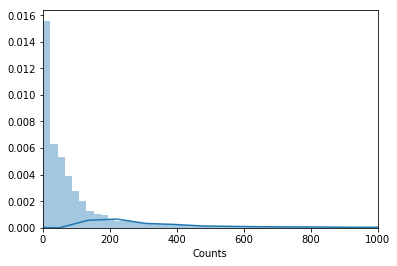

In [25]:
### Distribution of counts
ax2 = sns.distplot(movie_rec_counts["Counts"],bins=500)
ax2.set_xlim(0,1000)